In [2]:
import tensorflow as tf, numpy as np
import random
import pandas as pd
import nltk
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_context('poster')

## Restore the data in pickle

In [4]:
import pickle
with open('simple2_save.pickle', 'rb') as f:
    save = pickle.load(f)
    adj_pos = save['adj_pos']
    adj_neg = save['adj_neg']
    adverb_no_change = save['adverb_no_change']
    adverb_change = save['adverb_change']
    adverb_neg = save['adverb_neg']
    adverb_pos = save['adverb_pos'] 
    dico_embedding = save['dico_embedding'] 
adjectives = [adj_neg, adj_pos]
adverbs = [adverb_no_change, adverb_change, adverb_neg, adverb_pos]

In [5]:
for data_name in save.keys():
    print("Longueur de %s : %d" % (data_name, len(eval(data_name))))

Longueur de dico_embedding : 805
Longueur de adverb_neg : 5
Longueur de adj_neg : 440
Longueur de adverb_change : 5
Longueur de adverb_pos : 5
Longueur de adverb_no_change : 5
Longueur de adj_pos : 343


### Routines pour générer les données 

In [6]:
class Example_Generator(object):
    
    def __init__(self, adjectives, adverbs):
        self.adverbs = adverbs
        n = min(len(adjs) for adjs in adjectives)
        permut = random.sample(range(n), 5*n//6)
        self.training_adjectives = [[adjs[i] for i in permut] for adjs in adjectives]
        self.validation_adjectives = [[adjs[i] for i in range(n) if i not in permut] 
                                 for adjs in adjectives]
        self.adjectives = adjectives        
        
    def generate_example(self):
        adv_ind = random.randint(0,3)
        adv = random.choice(self.adverbs[adv_ind])
        if adv_ind in [0, 2]: # on peut choisir parmi tous les adjectifs
            adj_ind = random.randint(0,1)
            adj = random.choice(self.adjectives[adj_ind])
        else: # adv_ind in [1, 3], on ne choisit que parmi les adjectifs de training
            adj_ind = random.randint(0,1)
            adj = random.choice(self.training_adjectives[adj_ind])
         
        sentence = ['This', 'is', adv, adj]
        label = int(adv_ind == 0 and adj_ind or # on NE change PAS le sentiment de l'adjectif
                    adv_ind == 1 and not adj_ind or # on change le sentiment de l'adjectif
                    adv_ind == 2 and 0 or # l'adverbe impose le sentiment négatif
                    adv_ind == 3) # l'adverbe impose le sentiment positif 
        return sentence, label
    
    def generate_validation(self):
        for i, adjs in enumerate(self.validation_adjectives):
            for adj in adjs:
                for adv in self.adverbs[1]:
                    label = int(not i)
                    yield ['This', 'is', adv, adj], label
                for adv in self.adverbs[3]:
                    label = 1
                    yield ['This', 'is', adv, adj], label

In [8]:
ex = Example_Generator(adjectives=adjectives, adverbs=adverbs)

In [14]:
type(generate_batch(ex, 1))
generate_batch(ex, 1)[0].shape
generate_batch(ex, 1)[1]

tuple

(4, 1, 50)

array([[[ 1.]]])

### Generate the batch

In [11]:
def generate_batch(example_generator, batch_size, size_embedding=50):
    x = np.empty([4, batch_size, size_embedding])
    y = np.empty([1, batch_size, 1])
    
    for j in range(batch_size):
        sentence_split, label = example_generator.generate_example()
        
        for i, w in enumerate(sentence_split):
            x[i,j,:] = dico_embedding[w]
            
        y[0,j,0] = label
    return x, y

def generate_validation_set(example_generator, size_embedding=50, validation_size=None):
    max_size = (2*len(example_generator.validation_adjectives[0])*
                2*len(adverbs[0]))
    if not validation_size or validation_size > max_size: 
        validation_adjectives = max_size
    x = np.empty([4, validation_size, size_embedding])
    y = np.empty([1, validation_size, 1])
    
    gen = example_generator.generate_validation()
    for j in range(validation_size):
        sentence_split, label = next(gen)
        
        for i, w in enumerate(sentence_split):
            x[i,j,:] = dico_embedding[w]
            
        y[0,j,0] = label
    return x, y

# Graph building and training

In [11]:
INPUT_SIZE = 50
OUTPUT_SIZE = 1
RNN_HIDDEN = 60
LEARNING_RATE = 0.01

DROPOUT = 0.5

TINY = 1e-7


NUM_EPOCHS = 60
ITERATONS_PER_EPOCH = 50
BATCH_SIZE = 500

In [12]:
#####################################################################
#############             Graph Definition             ##############
#####################################################################


with tf.Graph().as_default() as graph:
    # Definition of the inputs and outputs
    inputs = tf.placeholder(tf.float32, (None, None, INPUT_SIZE)) # time, batch_size, INPUT_S
    labels = tf.placeholder(tf.float32, (None, None, OUTPUT_SIZE))
    
    cell = tf.contrib.rnn.BasicLSTMCell(RNN_HIDDEN)
    
    # maybe add dropout
    if DROPOUT:
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=0.5, output_keep_prob=0.8)
    
    # Definition of the initial state
    batch_size = tf.shape(inputs)[1]
    initial_state = cell.zero_state(batch_size, tf.float32)

    # Computation of the outputs and states
    with tf.variable_scope('lstm_weights'):
        rnn_outputs, rnn_states = tf.nn.dynamic_rnn(cell, inputs, 
                                                    initial_state=initial_state, 
                                                    time_major=True)
        ## First by taking only the last step
        final_outputs = tf.slice(rnn_outputs, begin=(3,0,0), size=(1,-1,RNN_HIDDEN))
        ## Then by averaging on all states
        final_outputs = tf.reduce_mean(rnn_outputs, axis=0, keep_dims=True)
        _ = tf.summary.histogram('hidden_state', rnn_states)
        

    # Projection of the outputs
    final_projection = lambda x: tf.contrib.layers.linear(x, num_outputs=OUTPUT_SIZE, 
                                                          activation_fn=tf.nn.sigmoid)
    # Application of final projection to the outputs
    logits = tf.map_fn(final_projection, final_outputs)

    # Loss
    loss = -(labels*tf.log(logits + TINY) + (1.0 - labels)*tf.log(1.0 - logits + TINY))
    loss = tf.reduce_mean(loss)
    _ = tf.summary.scalar('loss', loss)

    # train_optimizer
    train_optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

    # For validation purpose
    accuracy = tf.reduce_mean(tf.cast(abs(logits - labels) < 0.5, tf.float32))
    _ = tf.summary.scalar('test_accuracy', accuracy)
    
    # Summaries
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('/home/louis/python/notebooks/.tensorflow_logs_dir/', 
                                   graph=graph)

In [13]:
###########################################################################
########                         Training Loop                     ########
###########################################################################

eg = Example_Generator(adjectives, adverbs)
valid_x, valid_y = generate_validation_set(eg, validation_size=300)

logs = defaultdict(list)
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    for i in range(NUM_EPOCHS):
        epoch_loss = 0
        for j in range(ITERATONS_PER_EPOCH):
            x, y = generate_batch(eg, batch_size=BATCH_SIZE)
            epoch_loss, _, train_accuracy = session.run([loss, train_optimizer, accuracy], 
                                                         feed_dict={inputs:x, 
                                                              labels:y})
            # Summaries
            # ind = i*ITERATONS_PER_EPOCH + j
            # if ind%10 == 0:
            #     writer.add_summary(summaries, ind)
                
        epoch_loss /= ITERATONS_PER_EPOCH
        valid_accuracy = session.run(accuracy, 
                                     feed_dict={inputs:valid_x, labels:valid_y})
        print('Iteration : %d, Epoch Loss = %.8f' % (i, epoch_loss))
        print('Accuracy = %.1f' % (valid_accuracy*100.))
        
        logs['epoch_loss'].append(epoch_loss)
        logs['train_accuracy'].append(train_accuracy)
        logs['valid_accuracy'].append(valid_accuracy)
        
        if valid_accuracy == 1 or i == NUM_EPOCHS: break

Iteration : 0, Epoch Loss = 0.00780467
Accuracy = 73.3
Iteration : 1, Epoch Loss = 0.00677003
Accuracy = 84.0
Iteration : 2, Epoch Loss = 0.00554666
Accuracy = 85.3
Iteration : 3, Epoch Loss = 0.00505209
Accuracy = 86.7
Iteration : 4, Epoch Loss = 0.00416861
Accuracy = 86.7
Iteration : 5, Epoch Loss = 0.00404794
Accuracy = 89.0
Iteration : 6, Epoch Loss = 0.00422734
Accuracy = 89.3
Iteration : 7, Epoch Loss = 0.00355615
Accuracy = 86.7
Iteration : 8, Epoch Loss = 0.00466855
Accuracy = 88.7
Iteration : 9, Epoch Loss = 0.00338868
Accuracy = 87.3
Iteration : 10, Epoch Loss = 0.00369896
Accuracy = 89.7
Iteration : 11, Epoch Loss = 0.00280010
Accuracy = 88.0
Iteration : 12, Epoch Loss = 0.00338202
Accuracy = 86.7
Iteration : 13, Epoch Loss = 0.00250375
Accuracy = 89.3
Iteration : 14, Epoch Loss = 0.00272674
Accuracy = 91.3
Iteration : 15, Epoch Loss = 0.00273740
Accuracy = 89.0
Iteration : 16, Epoch Loss = 0.00304411
Accuracy = 91.7
Iteration : 17, Epoch Loss = 0.00269557
Accuracy = 88.7
It

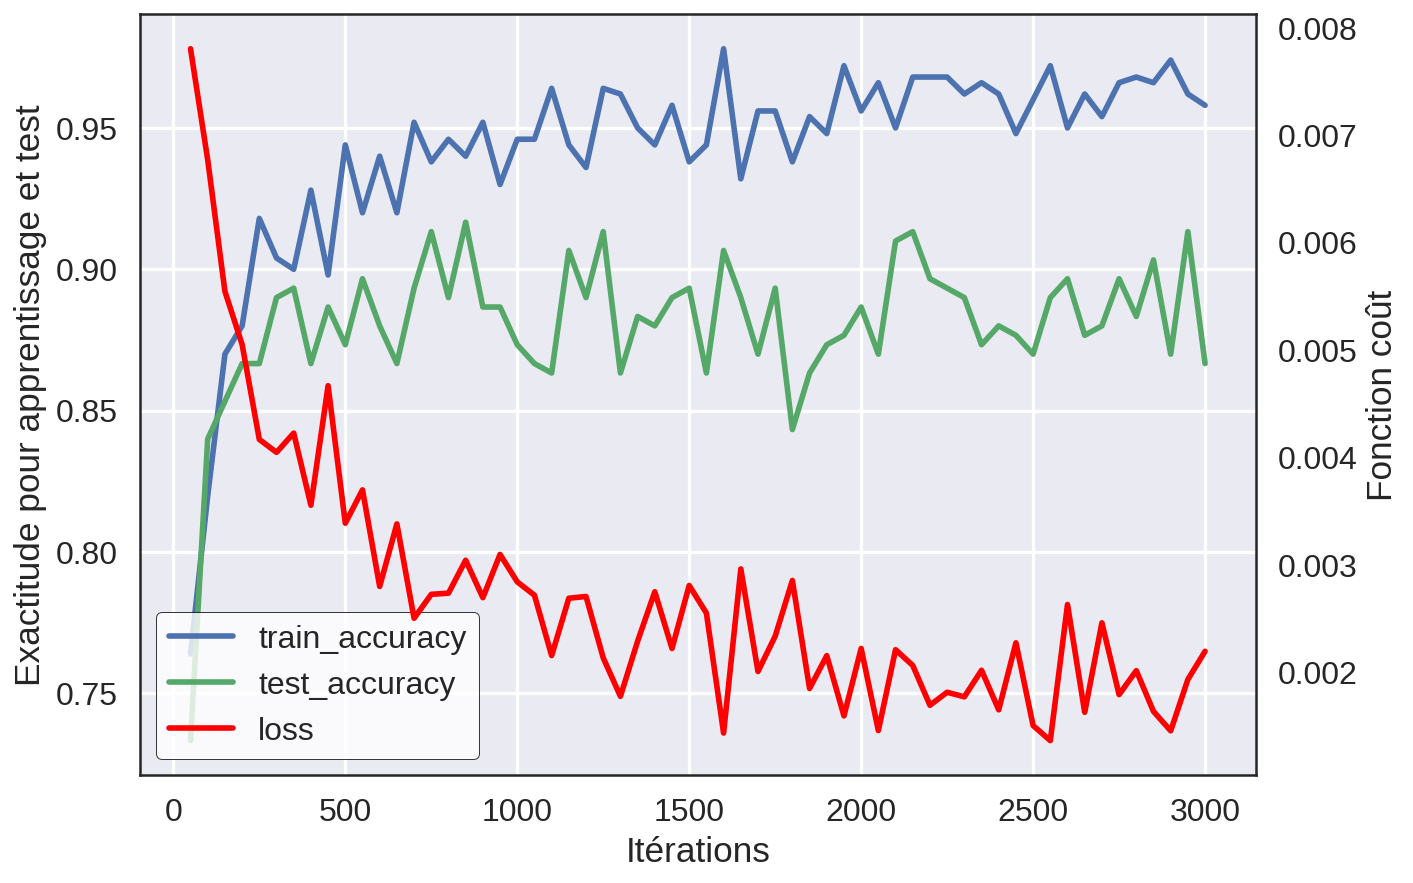

In [50]:
supp = range(ITERATONS_PER_EPOCH, NUM_EPOCHS*ITERATONS_PER_EPOCH+1, ITERATONS_PER_EPOCH)
with plt.rc_context({'figure.figsize': (10, 7)}):
    l1 = plt.plot(supp, logs['train_accuracy'])
    ax = plt.gca()
    l2 = ax.plot(supp, logs['valid_accuracy'])
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Exactitude pour apprentissage et test')
    with sns.axes_style('white'):
        ax2 = ax.twinx()
        l3 = ax2.plot(supp, logs['epoch_loss'], color='red')
        ax2.set_ylabel("Fonction coût")
    ax.legend(l1+l2+l3, ['train_accuracy', 'test_accuracy', 'loss'], loc='lower left', 
              frameon=True)
    frame = ax.legend_.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
1;